In [2]:
# test display file root

import sys
import matplotlib.pyplot as plt
import numpy as np    
import cygnus_lib as cy

# mostra tutte le imagini e tracce del file ROOT

Welcome to JupyROOT 6.22/06
Open file: https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/Data/LAB/histograms_Run04392.root
Find Keys: 28
# of Images (TH2) Files: 7 
# of Waveform (TH2) Files: 21 
Camera X, Y pixel: 2304 2304 


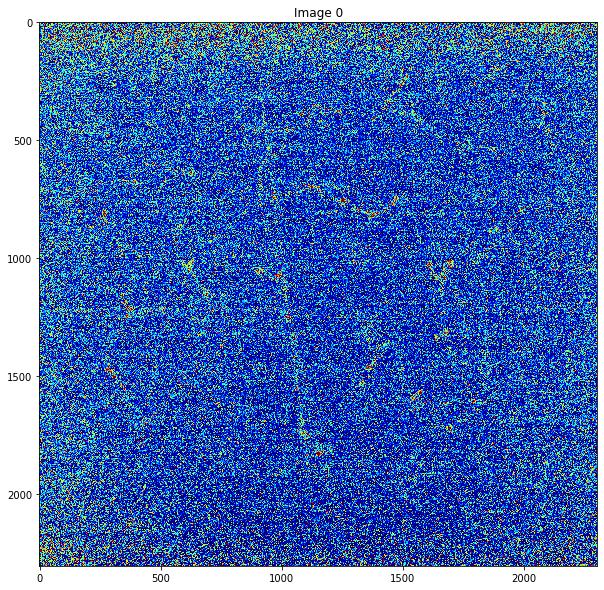

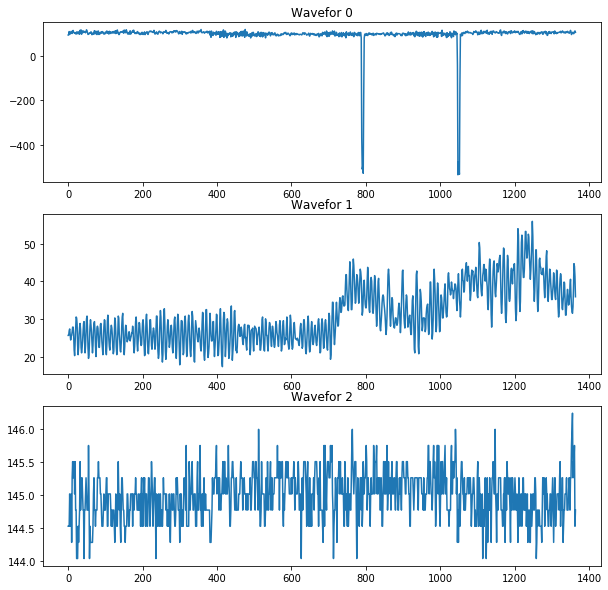

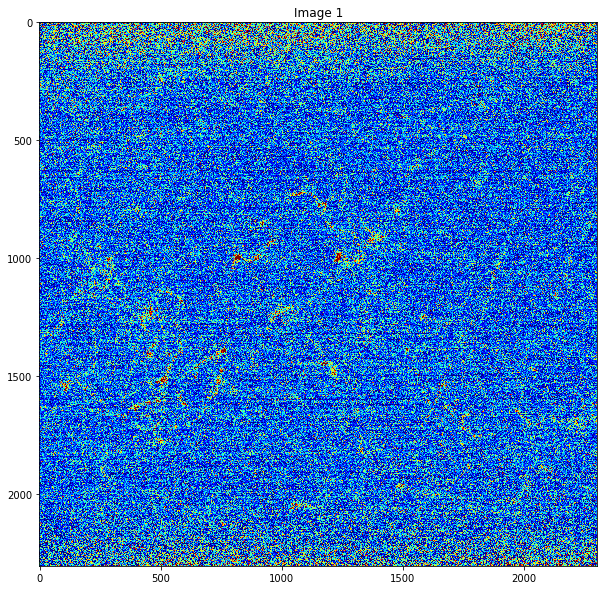

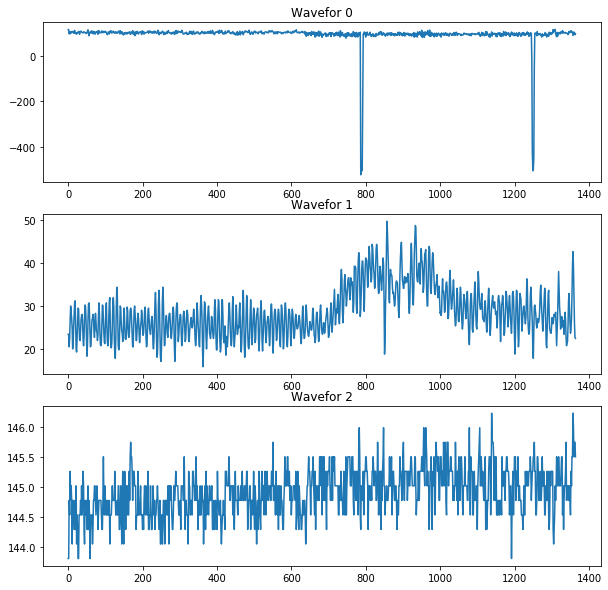

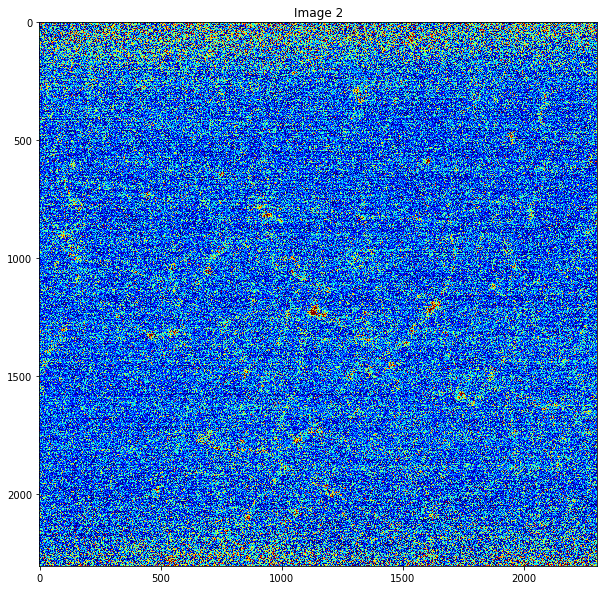

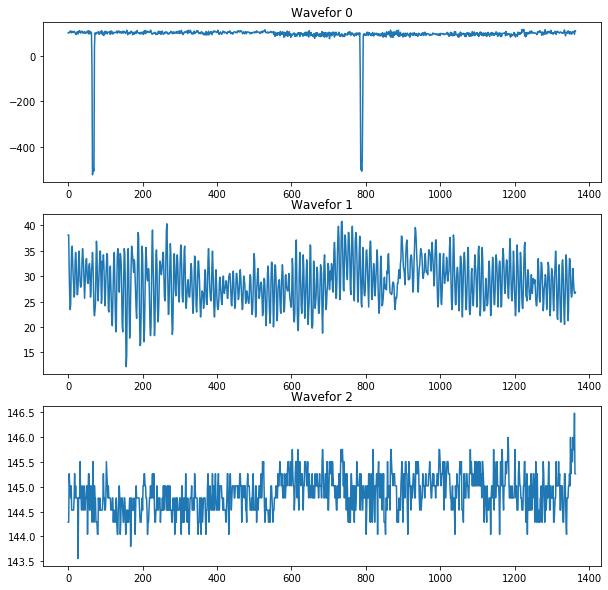

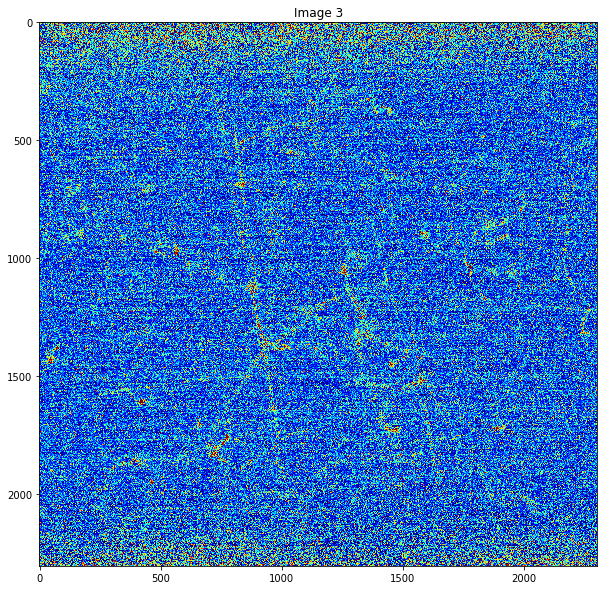

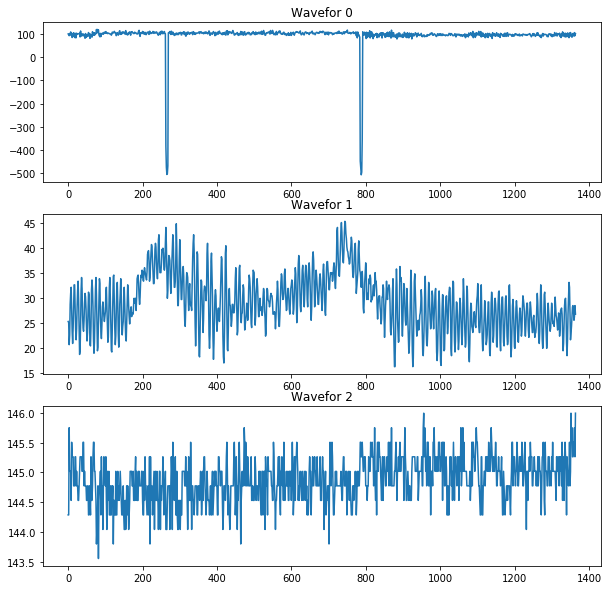

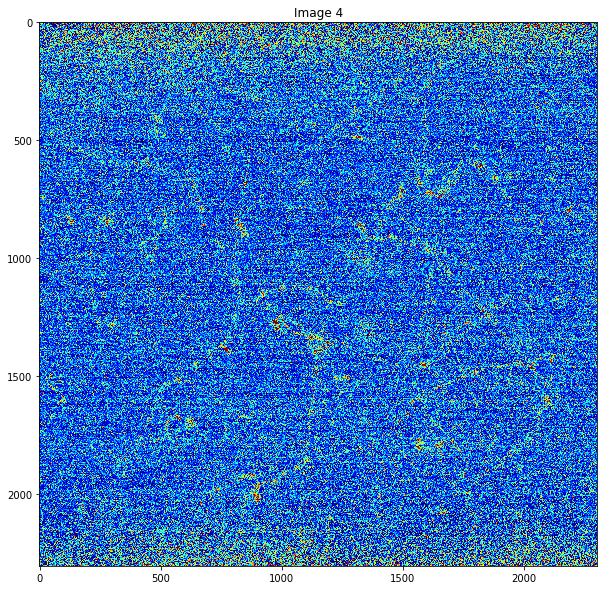

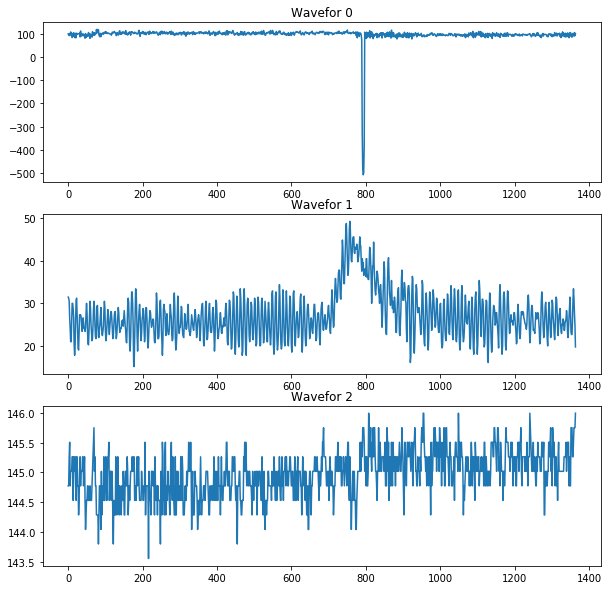

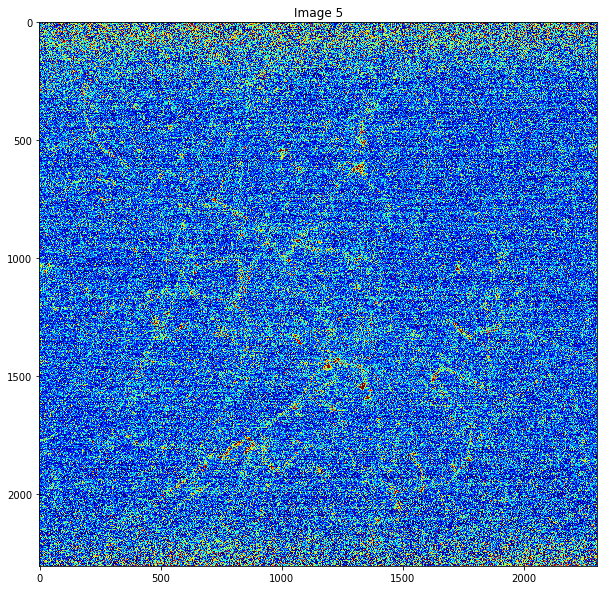

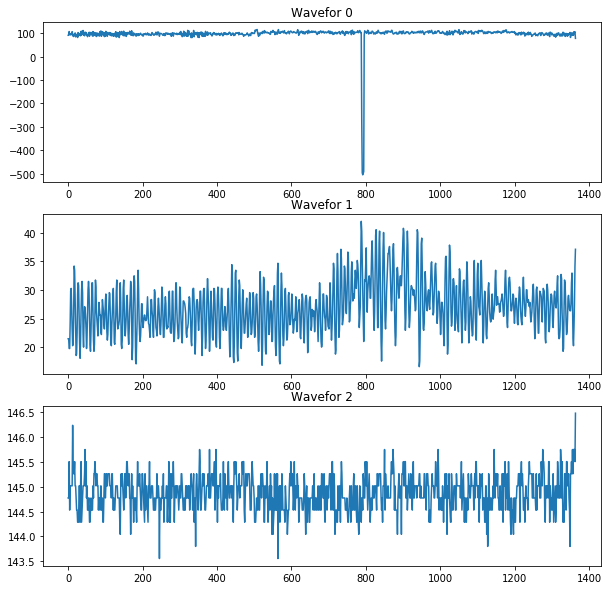

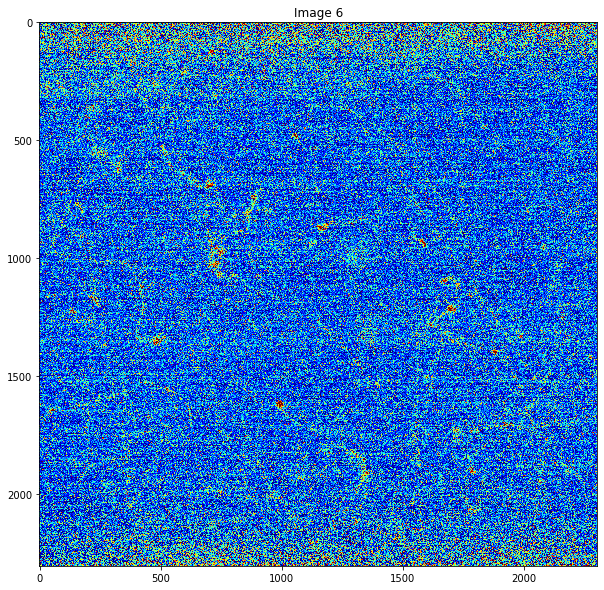

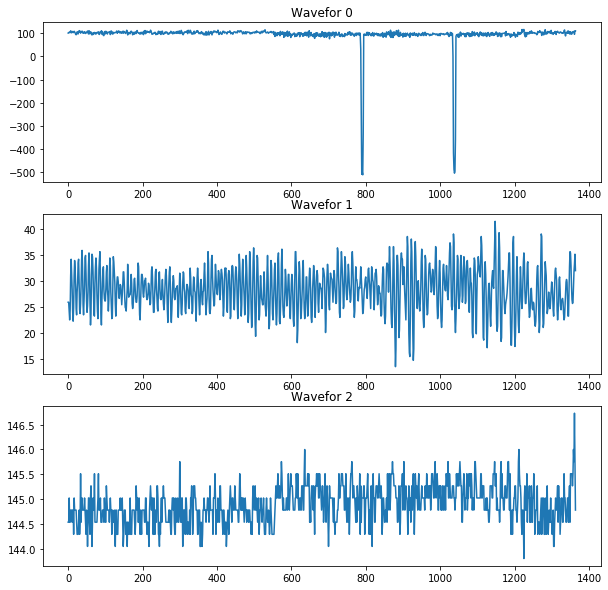

In [3]:
cfile = cy.open_(run=4392, tag='LAB', posix=False, verbose=True)
wfm_module=int(cfile.max_wfm/cfile.max_pic)
for iTr in range(cfile.max_pic):
    fig, ax = plt.subplots (1, figsize=(10,10))
    image = cy.pic_(cfile, iTr)
    ax.imshow(image,  cmap="jet", vmin=95,vmax=120, aspect="auto")
    ax.set_title("Image {:d}".format(iTr))
    plt.plot()
    fig, ax = plt.subplots (wfm_module, figsize=(10,10))
    for iWf in range(wfm_module):   
        #print (iTr, iWf, iTr*wfm_module+iWf)
        t,a = cy.wfm_(cfile, iTr, iWf)
        ax[iWf].plot(t,a)
        ax[iWf].set_title("Wavefor {:d}".format(iWf))
    plt.plot()

In [5]:
cfile = cy.open_(run=4392, tag='LAB', posix=True, verbose=True)
image = cy.pic_(cfile,1)

Open file: /workarea/cloud-storage/cygnus/Data/LAB/histograms_Run04392.root
Find Keys: 28
# of Images (TH2) Files: 7 
# of Waveform (TH2) Files: 21 
Camera X, Y pixel: 2304 2304 


INFO: mean: 101.33, sigma: 6.54, N out of range: 1781 < vmin=80, 43599 > vmax=120, insane: 0


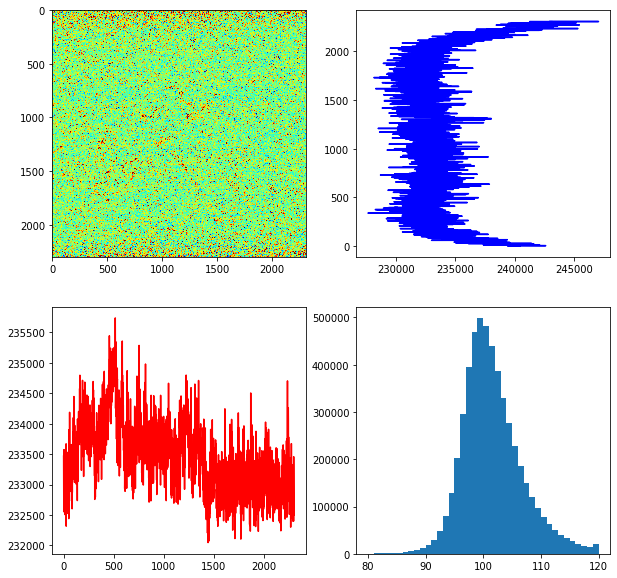

In [6]:
cy.img_proj(image, vmin=80, vmax=120, log=False)

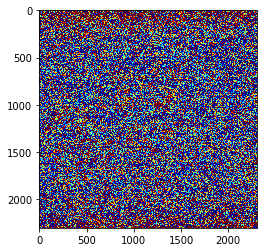

In [7]:
plt.imshow(image,cmap="jet", vmin=98, vmax=105)
plt.show()

In [8]:
mybasepath = '/workarea/cloud-storage/mazzitel/'
m_image, s_image = cy.ped_(4038, path=mybasepath+'ped/')

/workarea/cloud-storage/mazzitel/ped/run4038_mean.h5 /workarea/cloud-storage/mazzitel/ped/run4038_sigma.h5


INFO: mean: 0.77, sigma: 6.36, N out of range: 2446 < vmin=-20, 39356 > vmax=20, insane: 0


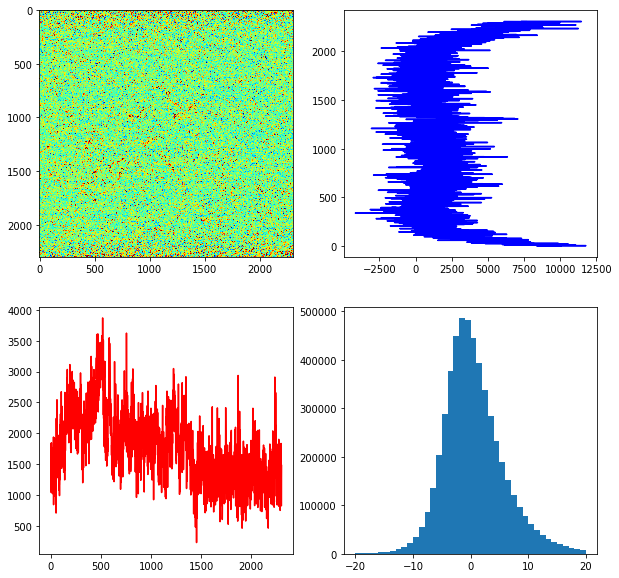

In [9]:
cy.img_proj(image-m_image, vmin=-20, vmax=20, log=False)

In [10]:
rescale = 576
nsigma=1
cimax         = 10
cimin         = 0 

th_image   = np.round(m_image + nsigma*s_image)
raw_image       = np.subtract(image,m_image)
rebin_image     = cy.rebin(raw_image, (rescale, rescale))  
rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))
edges = (rebin_image > rebin_th_image) & (rebin_image < cimax)
points          = np.array(np.nonzero(edges)).T.astype(float)

INFO: mean: 104.26, sigma: 6.78, N out of range: 1 < vmin=90, 40544 > vmax=110, insane: 0


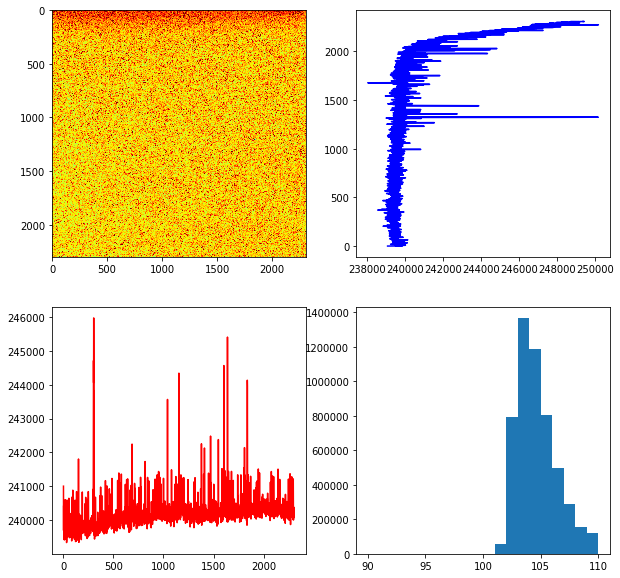

In [11]:
cy.img_proj(th_image, vmin=90, vmax=110, log=False)

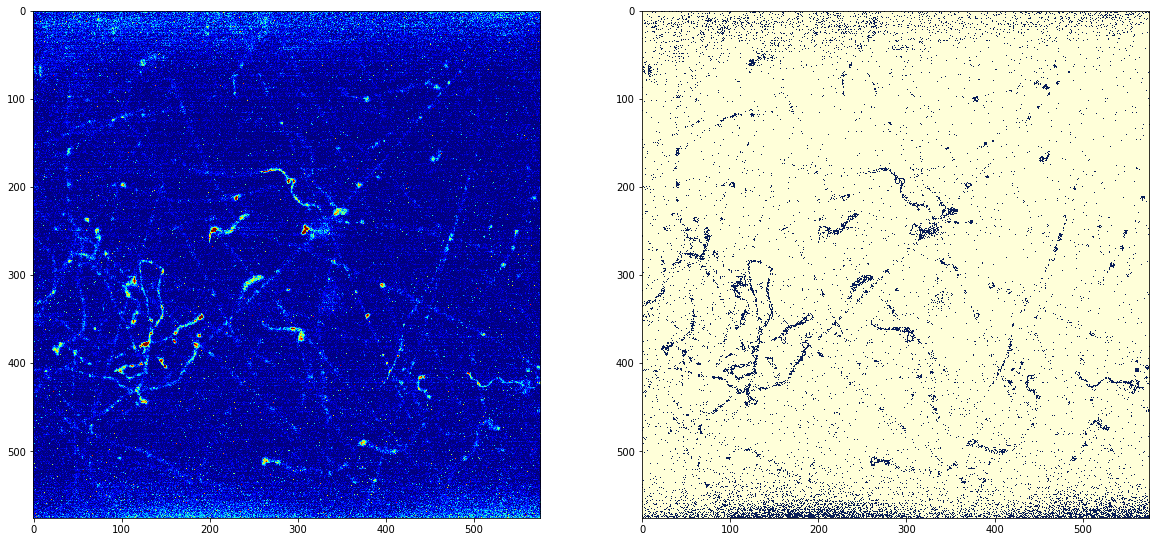

In [12]:
fig, ax = plt.subplots (1,2, figsize=(20,10))
ax[0].imshow(rebin_image, cmap='jet', vmin=0, vmax=20)
ax[1].imshow(edges, cmap='YlGnBu', vmin=0,vmax=1)
plt.show()

# area di debug 

In [64]:
def TGraph2array(tgraph):
    import ctypes
    xl = []; yl = []
    for i in range(tgraph.GetN()):
        xi = ctypes.c_double(); yi = ctypes.c_double()
        tgraph.GetPoint(i,xi,yi)
        xl.append(xi.value)
        yl.append(yi.value)
    x = np.array(xl)
    y = np.array(yl)
    return x, y
class myError(Exception):
    pass

class cfile:
    def __init__(self, file, pic, wfm, max_pic, max_wfm, x_resolution, y_resolution):
        self.file         = file
        self.pic          = pic 
        self.wfm          = wfm
        self.max_pic      = max_pic
        self.max_wfm      = max_wfm
        self.x_resolution = x_resolution
        self.y_resolution = y_resolution
        
def s3_root_file(run, tag='LAB', posix=True):
    if posix:
        BASE_URL  = "/workarea/cloud-storage/cygnus/"
    else:
        BASE_URL  = "https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/"
    file_root = ('Data/'+tag+'/histograms_Run%05d.root' % run)
    return BASE_URL+file_root
def open_(run, tag='LAB', posix=False, verbose=True):
    import ROOT
    import root_numpy as rtnp
    class cfile:
        def __init__(self, file, pic, wfm, max_pic, max_wfm, x_resolution, y_resolution):
            self.file         = file
            self.pic          = pic 
            self.wfm          = wfm
            self.max_pic      = max_pic
            self.max_wfm      = max_wfm
            self.x_resolution = x_resolution
            self.y_resolution = y_resolution
    try:
        f=ROOT.TFile.Open(s3_root_file(run, tag, posix=posix))
        pic, wfm = root_TH2_name(f)
        image = rtnp.hist2array(f.Get(pic[0])).T
        x_resolution = image.shape[1]
        y_resolution = image.shape[0]
        max_pic = len(pic)
        max_wfm = len(wfm)
    except:
        raise myError("openFileError: "+s3_root_file(run, tag, posix=posix))
    

    if verbose:
        print ('Open file: '+s3_root_file(run, tag, posix=posix))
        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        print ("# of Images (TH2) Files: %d " % (max_pic))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))
        print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))
    return cfile(f, pic, wfm, max_pic, max_wfm, x_resolution, y_resolution)

def pic_(cfile, iTr):
    import ROOT
    import root_numpy as rtnp
    pic, wfm = root_TH2_name(cfile.file)
    image = rtnp.hist2array(cfile.file.Get(pic[iTr])).T
    return image

def wfm_(cfile, iTr, iWf):
    import ROOT
    import root_numpy as rtnp
    wfm_module=int(cfile.max_wfm/cfile.max_pic)
    if (iTr > cfile.max_pic) or (iWf > wfm_module):
        raise myError("track or wawform out of ragne {:d} {:d}".format(cfile.max_pic, wfm_module))
    i = iTr*wfm_module+iWf
    pic, wfm = root_TH2_name(cfile.file)
    t,a = TGraph2array(cfile.file.Get(wfm[i]))
    return t,a


def root_TH2_name(root_file):
    pic = []
    wfm = []
    for i,e in enumerate(root_file.GetListOfKeys()):
        che = e.GetName()
        if ('pic_run' in str(che)):
            pic.append(che)
        elif ('wfm_run' in str(che)):
            wfm.append(che)
    return pic, wfm


In [60]:
cfile = open_(run=4392, tag='LAB', posix=False, verbose=True)

Open file: https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygnus/Data/LAB/histograms_Run04392.root
Find Keys: 28
# of Images (TH2) Files: 7 
# of Waveform (TH2) Files: 21 
Camera X, Y pixel: 2304 2304 


In [47]:
pic_(cfile, 1)

array([[ 97.,  89.,  92., ..., 108., 119., 107.],
       [114., 109.,  91., ..., 101.,  97., 108.],
       [117., 105.,  93., ...,  92., 112., 111.],
       ...,
       [102.,  99., 103., ..., 104.,  89.,  99.],
       [ 87.,  96.,  94., ..., 116.,  87., 113.],
       [127., 100., 109., ..., 104., 122., 114.]], dtype=float32)

In [52]:
wfm_(cfile, 7, 1)

(array([0.000000e+00, 1.333000e+00, 2.666000e+00, ..., 1.360993e+03,
        1.362326e+03, 1.363659e+03]),
 array([144.28710938, 144.28710938, 145.26367188, ..., 146.484375  ,
        145.26367188, 145.26367188]))